<a href="https://colab.research.google.com/github/claireporter/stylecheck/blob/main/stylecheckAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Irish Examiner Style Guide Check using Open AI and Pinecone!

## Import libraries

In [1]:
!pip install openai==0.28
# tiktoken only needed for cost evaluation, not actual runnind of the model on the article
!pip install tiktoken
!pip install -qU \
    pinecone-client==3.0.2 \
    openai==0.28.0

import openai
import json
import os

# time only needed for speed evaluation
import time
# tiktoken only needed for cost evaluation, not actual running of the model on the article
import tiktoken
# reading google sheet file
import pandas as pd

from pinecone import Pinecone, ServerlessSpec
from google.colab import drive, userdata

api_key = userdata.get('OPENAI_API_KEY')
openai.api_key = api_key

## Used for form in google colab
import ipywidgets as widgets
from IPython.display import display, HTML




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 5.0 MB/s eta 0:00:00


In [2]:
# Add in the data file
if not os.path.exists('data'):
    os.makedirs('data')

# Step 2: Download the file directly from the GitHub raw URL
#file_url = "https://raw.githubusercontent.com/claireporter/stylecheck/data/Style_Guide_Test.xlsx"  # Replace with the actual raw URL
file_url = "https://raw.githubusercontent.com/claireporter/stylecheck/main/data/Style_Guide_Test.xlsx"
destination_path = "data/Style_Guide_Test.xlsx"

# Use wget to download the file
!wget -O {destination_path} {file_url}

print(f"File has been downloaded to: {destination_path}")

--2025-01-15 07:37:39--  https://raw.githubusercontent.com/claireporter/stylecheck/data/Style_Guide_Test.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-01-15 07:37:40 ERROR 404: Not Found.

File has been downloaded to: data/Style_Guide_Test.xlsx


## **INPUT OPTIONAL**
## Adjust costs - costs below are for 2024 and depending on product plans, region

In [ ]:
# Open AI Costs - Adjust according to open ai model pricing

# Embedding model cost - text_embedding_3_large
text_embedding_3_large_tokens_cost_per_million = 0.13
#  Gen AI cost -  gpt-4o-mini
gpt4o_mini_input_tokens_cost_per_million =  0.150 # ($s)
gpt4o_mini_output_tokens_cost_per_million = 0.6 # ($s)

# Pinecone costs - currently using free plan, but these are miniumum prices for the Standard plan

# Price per GB - Adjust based on your pricing region
storage_cost_per_gb = 0.33
# Pinecone pricing for read units - adjust according to pinecone plan
read_cost_per_million = 16
# Pinecone pricing for write units - adjust according to pinecone plan
write_cost_per_million = 4


# Calculate costs

In [ ]:
# Calculate Pinecone cost
def calculate_pinecone_cost(read_units, write_units, storage_cost_per_gb, vector_size_in_bytes, num_vectors):
    # Calculate storage cost
    storage_cost = (num_vectors * vector_size_in_bytes) / 1e9 * storage_cost_per_gb

    # Costs for read and write units
    read_cost_per_unit = read_cost_per_million/1_000_000
    write_cost_per_unit = write_cost_per_million/1_000_000
    total_cost = (read_units * read_cost_per_unit) + (write_units * write_cost_per_unit) + storage_cost

    return total_cost

def calculate_token_usage_cost(tokens, cost_per_million):
     cost_per_one_token = cost_per_million / 1000000
     return (tokens * cost_per_one_token)

def get_token_costs(model):

    input_tokens_cost_per_million = gpt4o_mini_input_tokens_cost_per_million
    output_tokens_cost_per_million = gpt4o_mini_output_tokens_cost_per_million
    return input_tokens_cost_per_million, output_tokens_cost_per_million

In [ ]:
# create a data directory inside "/content"
#!mkdir -p /content/data



#### **INPUT REQUIRED**
Create a data directory inside /content

#### **INPUT REQUIRED**
Manually upload the Style_Guide_Test.xlsx from this repository to the 'data' directory


## Install the guidelines data

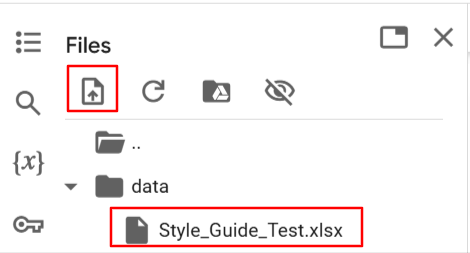

In [5]:
xlsx_file_path = "/content/data/Style_Guide_Test.xlsx"
##df = pd.read_excel(xlsx_file_path, sheet_name="Data Sheet")

##xlsx_file_path = destination_path # Update xlsx_file_path with downloaded file
df = pd.read_excel(xlsx_file_path, sheet_name="Data Sheet")


ValueError: Excel file format cannot be determined, you must specify an engine manually.

#### **INPUT REQUIRED**
#### Allow access to Google Drive
#### **INPUT REQUIRED**
#### Set up Pinecone
#### Save PCapi.txt file to drive to connect to Pinecone

In [ ]:
# Load guidelines as google sheet and do pinecone prep ie create pinecone embeddings
drive.mount('/content/drive')

with open('/content/drive/MyDrive/PCapi.txt', 'r') as file:
    PCApi = file.read().strip()

Mounted at /content/drive


In [ ]:
# Lets view the structure of the guidelines

# Select specific columns and rename them
df_subset = df[['ID', 'Style Point', 'Our Style', 'Correct usage', 'Incorrect usage', 'Keywords', 'Type', 'Replace']].head(7)
df_subset = df_subset.rename(columns={
    'Style Point': 'Style Point (Style Name)',
    'Our Style': 'Our Style (Style Description)'
})
df_subset = df_subset.fillna("")
# Display the result
df_subset

,ID,Style Point (Style Name),Our Style (Style Description),Correct usage,Incorrect usage,Keywords,Type,Replace
0,1.0,**a or an before h**,Use **an** if the noun/adjective following beg...,It was an hour later that the bell rang.\n \n ...,She stayed in an hotel on the beach.\n \n \n I...,a or an before h,3,
1,2.0,**A&E**,"In body copy, use **emergency department**. Do...",,,A&E,1,Emergency Department
2,5.0,"**aborigines, Aborigines**",Use aborigines when referring to indigenous po...,"The indigenous peoples of Taiwan, or Taiwan ab...",Taiwan’s Aborigines have lived on the island f...,"indigenous peoples, indigenous populations, ab...",2,
3,6.0,"**About, around**",We use **around** to indicate a physical area....,I got home from work at about 1am.\n \n \n I d...,I got home around 1am.\n \n \n I drove about t...,"around, about",2,
4,7.0,"**Absence, absenteeism**",**Absence** is not the same as **absenteeism**...,Absence makes the heart grow fonder.\n \n \n T...,Half the staff caught covid leading to a high ...,"absence, absenteeism",2,
5,8.0,"**Accents, fadas**","Use accents or fadas as required for Irish, Fr...",Tá Dáithí Ó Mathghamhna ag dul go dtí an crech...,,"Accents, fadas",4,
6,9.0,**Accidents and collisions**,Use accident if nobody or nothing is at fault....,The death was ruled a tragic accident.\n \n \n...,Gardaí are investigating the cause of the acci...,Accidents and collisions,3,


##### The Type of guideline defines how we identify it

1 - is a simple search / replace - could be done without AI (Search for Keywords; suggested replacement from 'Replace' column

2 - search using Keywords (checking each item in comma-delimited list) (not AI)

3 - semantic meaning search using Pinecone dense vectors (RAG AI)

4 - Always check this rule

In [ ]:
display(HTML('''
<style>
     label {
         display: block;
         margin-bottom: 5px;
         font-weight: bold;
         width: 100%;
     }
     select, textarea {
         width: 100%;
         padding: 10px;
         margin-bottom: 15px;
         border: 1px solid #ccc;
         border-radius: 4px;
         font-size: 14px;
         height: 100%;
     }
     button {
         background-color: #4CAF50;
         color: white;
         padding: 10px 20px;
         border: none;
         border-radius: 4px;
         cursor: pointer;
         font-size: 16px;
     }
     button:hover {
         background-color: #45a049;
     }
 </style>
'''))

model_dropdown = widgets.Dropdown(
    options=['gpt-4o-mini'],
    value='gpt-4o-mini',
    description='Model:',
    layout=widgets.Layout(width='30%', height='50px')
)

# Sample text from an article for initial test

input_text = widgets.Textarea(value='He easily adapts to the latest technology.\nPeople run the 1,500m and take part in a 5,000m race. \nHe was an early adopter of the new technology.\nThe newspaper goes to press at 10:30 PM.\nThe car collided with a pedestrian.\nHis excellency, the archbishop was there',
    placeholder='Type the input text here',
    description='Article:',
    layout=widgets.Layout(width='80%', height='375px')
)

output = widgets.Output()

generate_button = widgets.Button(description="Generate Output")


def on_generate_button_click(b):
    with output:
        output.clear_output()
        try:
          generate_output(input_text.value, model_dropdown.value)
        except AttributeError as e:
          print("AttributeError:", e)
        except Exception as e:
          print("An error occurred:", e)



# Create pinecone index


In [ ]:
pinecone = Pinecone(api_key=PCApi)

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'
spec = ServerlessSpec(cloud=cloud, region=region)

index_name = 'semantic-search-fast3'
pinecone.delete_index(index_name)

pinecone.create_index(
    name='semantic-search-fast3',
    #dimension=1536,  # 1536 is the dimension used with text-embedding-ada-002 or 3072 for text-embedding-3-small (if used)
    dimension=3072,  # 3072 is the dimension used with text-embedding-3-large
    metric='dotproduct',
    spec=spec
)
index = pinecone.Index('semantic-search-fast3')

## Prepare lists of rules and entries

In [ ]:


df['Style Point'] = df['Style Point'].str.replace('**', '', regex=False)

# Replace null values in keywords with 'Our Style' column
df['Our Style'].fillna(df['Keywords'], inplace=True)
df['Our Style'].replace('', 'placeholder text', inplace=True)
df['Our Style'].fillna('placeholder text', inplace=True)

df_filtered = df[df["Type"] == 3]


ID_list = df_filtered["ID"].tolist()
type_list = df_filtered["Type"].tolist()
keywords_list = df_filtered["Keywords"].tolist()

rule_list = df_filtered.apply(
    lambda row: (
        row["Style Point"] + ' ' +
        row["Our Style"] +
        (' Examples of correct usage: ' + row["Correct usage"] if pd.notna(row["Correct usage"]) and row["Correct usage"] != '' else '') +
        (' Examples of incorrect usage: ' + row["Incorrect usage"] if pd.notna(row["Incorrect usage"]) and row["Incorrect usage"] != '' else '')
    ),
    axis=1
).tolist()

#print(f"rule_list: {rule_list}")
# TO REMOVE - Keep track of rule ids to check what is going into embeddings.
rule_ids = df_filtered["ID"].tolist()

# Remove final , in csv of keywords if exists
def clean_comma_delimited_list(myListString):
  if myListString.endswith(','):
      myListString = myListString[:-1]
  return myListString

def limit_rule_ids(matched_rule_ids):

    # make a hard limit of rules in case too many are found
    limit_rules_genai = 20

    if len(matched_rule_ids) >= limit_rules_genai:

        matched_rule_ids = matched_rule_ids[:limit_rules_genai]

    rule_ids_comma_delimited_string = ",".join(map(str, matched_rule_ids))
    return rule_ids_comma_delimited_string


# Narrow down rules from guideline to a subset to run in a prompt.

*   More performant
*   Less cost (fewer tokens)

## Pinecone settings

###### Setting the score needs experimentation.

###### If too many false positive found, consider:

*   increasing the score
*  improving the comprehensibility of the guidelines found by pinecone search (in our case, type 3 rules)





In [ ]:
def narrow_down_rules(textToValidate):

  top_k = 10  # Limit number of results to return by pinecone query to ensure efficiency.

  matched_rule_ids_all = []
  matched_rule_ids_string_search_with_ai = []
  matched_rule_ids_dense = []
  matched_rule_ids_always = []

  for i in range(len(df)):
      myType = df.loc[i, 'Type']
      rule_id = df.loc[i, 'ID']
      keyword_csv = df.loc[i, 'Keywords']
      keyword_csv = clean_comma_delimited_list(keyword_csv)

      # FIND TYPE 2 RULES - Do string search for rules with a list of keywords to match in the article

      if myType == 2:
          relevant_sentences = []
          matched = False  # Reset matched for each rule

          for keyword in keyword_csv.split(','):
              keyword = keyword.strip().lower()

              # find matches to keywords of complete words only
              matched_sentences = [
                sentence.strip() for sentence in textToValidate.split('.')
                if (f" {keyword} " in f" {sentence.lower()} " or  # keyword in the middle
                  sentence.lower().startswith(f"{keyword} ") or  # keyword at the start
                  sentence.lower().endswith(f" {keyword}"))      # keyword at the end
              ]

              if matched_sentences:
                  matched = True
                  myID = int(df.loc[i, 'ID'])
                  myKeywords = df.loc[i, 'Keywords']
                  relevant_sentences.extend(matched_sentences)
                  break  # Stop checking further if a match is found within this rule
          if matched:
            sentenceCount = 0
            for sentence in relevant_sentences:
                sentenceCount += 1
                print(f"Found {myKeywords} in {sentenceCount} sentences, Rule ID: {myID}")
                print(f"Sentence: '{sentence}'")
                if myID not in matched_rule_ids_string_search_with_ai:
                  matched_rule_ids_string_search_with_ai.append(str(int(myID)))

          # Convert ID array to strings - to match format of dense array
          matched_rule_ids_string_search_with_ai = [str(item) for item in matched_rule_ids_string_search_with_ai]

      # FIND TYPE 4 RULES

      elif myType == 4:
        myID = int(df.loc[i, 'ID'])
        matched_rule_ids_always.append(str(int(myID)))

  # FIND TYPE 3 RULES

  # Generate embeddings a second time, for the article text
  # (in order to query against the stored rule embeddings)

  query_dense = get_embeddings([textToValidate])[0]

  # ========================================================

  # Calculate cost of embeddings creation for rule_list ...
  encoder = tiktoken.encoding_for_model("text-embedding-3-large")
  embedding_tokens_article = len(encoder.encode(textToValidate))

  # - for Open AI embeddings model

  embedding_article_cost = calculate_token_usage_cost(embedding_tokens_article, text_embedding_3_large_tokens_cost_per_million)

  print(f"Embedding tokens used for article: {embedding_tokens_article}")
  print(f"Cost for embeddings for article: ${embedding_article_cost:.6f}")

  # = for Pinecone

  query_vectors = 1  # Number of query vectors (textToValidate)
  read_units = query_vectors * (top_k / 10)  # 1 read unit per 10 results

  pinecone_cost_query = calculate_pinecone_cost(read_units, 0, 0, 0, 0)  # Only read units
  print(f"Pinecone cost currently free on starter plan but estimate based on lowest rate for standard plan:\n  Pinecone Cost for querying: ${pinecone_cost_query:.6f}")

  #1 Query the index with dense embedding
  query_response = index.query(
        top_k=top_k,
        vector=query_dense,  # Running query on dense vector
        include_metadata=True
  )

  for match in query_response['matches']:
          keywords = match["metadata"]["keywords"]
          score = match["score"]
          myID = str(int(match["metadata"]["ID"]))
          myType = match["metadata"]["type"]


          print("myID", myID, " score:", score, "keywords:", keywords)


          if score > 0.28:  # Experiment with increasing/decreasing score to find more/less rules
            matched_rule_ids_dense.append(str(int(myID)))


  matched_rules_filtered = [item for item in matched_rule_ids_string_search_with_ai if item not in matched_rule_ids_dense]

  matched_rule_ids_all = matched_rule_ids_string_search_with_ai + matched_rule_ids_dense + matched_rule_ids_always

  print("Matched Rule IDs Type 2 - String search on keywords:", matched_rule_ids_string_search_with_ai)

  print(f"Matched Rule IDs Type 3 - Meaning search on keywords - Pinecone: ", matched_rule_ids_dense)

  print("Matched Rule IDs Type 4 - Always checked via prompt:", matched_rule_ids_always)

  print("All Matched Rule IDs:", matched_rule_ids_all)

  # Generate a formatted string of rules for matched_rule_ids_all
  string_of_rules = ""
  for rule_id in matched_rule_ids_all:
        row = df.loc[df['ID'] == int(rule_id)]
        if not row.empty:
            rule_text = (
                f"Rule {row['ID'].values[0]}\n"
                f"{row['Style Point'].values[0]}\n"
                f"{row['Our Style'].values[0]}\n"
            )
            # Add correct and incorrect usage examples if available
            if pd.notna(row['Correct usage'].values[0]):
                rule_text += f"This is correct usage:\n{row['Correct usage'].values[0]}\n"
            if pd.notna(row['Incorrect usage'].values[0]):
                rule_text += f"This is incorrect usage:\n{row['Incorrect usage'].values[0]}\n"

            # Append this rule text to the overall string with line breaks
            string_of_rules += f"{rule_text}\n\n"

  print(f"=============")
  return matched_rule_ids_all, embedding_tokens_article, embedding_article_cost, string_of_rules;



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-13-6922f3a204c9>:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Our Style'].fillna(df['Keywords'], inplace=True)


Embedding tokens used for rule_list: 11288
Cost for embeddings for rule_list: $0.001467
Pinecone Cost currently free on starter plan but estimate based on lowest rate for standard plan - for storing and upserting rules: $0.000317


{'upserted_count': 78}

# Generate embeddings using OpenAI's embeddings models

Our tests found text-embedding-3-large gave better results than text-embedding-ada-002 or text-embedding-3-small, from the Open AI suite of embedding models currently available

In [ ]:
def get_embeddings(rule_list):
    response = openai.Embedding.create(
        input=rule_list,
        model="text-embedding-3-large"
    )
    embeddings = [embedding['embedding'] for embedding in response['data']]

    return embeddings

# Generate embeddings the first time, from the rules, to store in pinecone
embeddings = get_embeddings(rule_list)

# Calculate costs for embeddings creation for rule_list

# - for Open AI model
encoder = tiktoken.encoding_for_model("text-embedding-3-large")
embedding_tokens_rule_list = sum([len(encoder.encode(text)) for text in rule_list])
text_embedding_3_large_tokens_cost_per_million = 0.13
embedding_rule_list_token_cost = calculate_token_usage_cost(embedding_tokens_rule_list, text_embedding_3_large_tokens_cost_per_million)

# Print token and cost information
print(f"Embedding tokens used for rule_list: {embedding_tokens_rule_list}")
print(f"Cost for embeddings for rule_list: ${embedding_rule_list_token_cost:.6f}")

# - for Pinecone
vector_size_in_bytes = 3072 * 4  # 3072 dimensions, float32 (4 bytes)
num_upsert_vectors = len(embeddings)  # Number of vectors stored

write_units = num_upsert_vectors / 1000  # 1 write unit per 1000 vectors

# Calculate Pinecone cost for storing and upserting vectors
pinecone_cost_rules = calculate_pinecone_cost(0, write_units, storage_cost_per_gb, vector_size_in_bytes, num_upsert_vectors)
print(f"Pinecone Cost currently free on starter plan but estimate based on lowest rate for standard plan - for storing and upserting rules: ${pinecone_cost_rules:.6f}")




## Prepare records for upsert in Pinecone

In [ ]:
records = []
for i in range(len(embeddings)):
    ind_dic = {
        'id': f'vec{i+1}',
        'values': embeddings[i],
        'metadata': {
            'keywords': keywords_list[i],
            'rule': rule_list[i],
            'ID': ID_list[i],
            'type': type_list[i],
        }
    }
    records.append(ind_dic)


index.upsert(vectors=records)

## Use function call to set the json output format of prompt

In [ ]:
result_functions = [
    {
        'name': 'validate_article_compliance',
        'description': 'Validate article compliance with rules',
        'parameters': {
            'type': 'object',
            'properties': {
                'isArticleCompliantWithAllRules': {
                    'type': 'boolean',
                    'description': 'Indicates whether the article complies with all rules.'
                },
                'issuesOfNonCompliance': {
                    'type': 'array',
                    'items': {
                        'type': 'object',
                        'properties': {
                            'ruleID': {
                                'type': 'string',
                                'description': 'Rule ID'
                            },
                            'stylePoint': {
                                'type': 'string',
                                'description': 'Style Point'
                            },
                            'ourStyle': {
                                'type': 'string',
                                'description': 'Our Style'
                            },
                            'textWithProblem': {
                                'type': 'string',
                                'description': 'Text containing the compliance issue.'
                            },
                            'suggestedAlternative': {
                                'type': 'string',
                                'description': 'Suggested alternative text.'
                            },
                            'explanation': {
                                'type': 'string',
                                'description': 'Explanation of the issue.'
                            }
                        }
                    },
                    'description': 'List of compliance issues.'
                }
            }
        }
    }
]


# Run prompt using Open AI
## the latest models got the best results from our tests

In [ ]:
def get_compliance_check(guideline, text, matched_rule_ids, model, embedding_tokens_article, embedding_article_cost, string_of_rules):

    rule_ids_formatted_for_prompt = limit_rule_ids(matched_rule_ids)

    print('matched_rule_ids', matched_rule_ids)


    # Generate prompt preamble before listing all rules
    prompt = f"""Here are the rules. \n\n
        Go through rule IDs {string_of_rules} only) provided in the uploaded style guide (ignore all other rules), and in each case, state if the provided input text is compliant with each of the rules.
        In each case, state if the provided input text is compliant with each of the following rules.
        If the context is not found, do not apply the guideline, and state that the text is compliant.
        If the context is not certain, ignore the guideline and state that the rule is compliant.
        Provide an explanation in each case.
        Return a json array as a result.
        The json must have the format as stated in the function call
        There should be one result per rule ID that is not compliant in one array.
        Only the provided rules should be used and that any external information or assumptions should be excluded.
        Then there should be one overall value of isArticleCompliantWithAllRules (true/false). When a ruleID is output in Json format it as an Integer"""

    # Alternative prompt - also works
    #prompt = f"""You are the editor-in-chief at an international news agency, tasked with revising and verifying all copy before publication.
    #  Your responsibilities include:
    #  Reading Text Inputs: Analyze each text input against established guidelines.
    #  Go through rules  {string_of_rules}
    #  Output Requirements:
    #  Provide explanations for each non-compliant rule.
    #  Return a JSON array with:
    #  Each non-compliant rule ID.
    #  A single overall value of isArticleCompliantWithAllRules (true/false)."""

    # print("Generated Prompt:\n", prompt)

    send_prompt = (
        f"{prompt}\n\n"
        f"Guideline: {guideline}\n\n"
        f"Text: {text}\n\n"
    )


    start_time = time.time()
    response = openai.ChatCompletion.create(
        model=model,
        messages=[{"role": "user", "content": send_prompt}],
        temperature=0,
        functions = result_functions,
        function_call = 'auto'
    )

    # Get costs of tokens depending on model used
    genai_input_tokens_cost_per_million, genai_output_tokens_cost_per_million = get_token_costs(model)

    # Get the input tokens
    usage = response['usage']
    genAI_input_tokens = usage['prompt_tokens']
    genAI_input_token_cost = calculate_token_usage_cost(genAI_input_tokens, genai_input_tokens_cost_per_million)
    print(f"GenAI Input tokens: {genAI_input_tokens} - cost this time: ${genAI_input_token_cost:.6f}")

    # Get the output tokens
    genAI_output_tokens = usage['completion_tokens']
    genAI_output_token_cost = calculate_token_usage_cost(genAI_output_tokens, genai_output_tokens_cost_per_million)
    print(f"GenAI Output tokens: {genAI_output_tokens} - cost this time: ${genAI_output_token_cost:.6f}")

    genAI_token_cost = genAI_input_token_cost + genAI_output_token_cost
    print(f"Total genAI cost this time: ${genAI_token_cost:.6f}")

    end_time = time.time()
    encoder = tiktoken.encoding_for_model(model)
    tokens = encoder.encode(send_prompt)

    # cost true as of 2024
    text_embedding_3_large_tokens_cost_per_million = 0.13

    tokens_embedding = sum([len(encoder.encode(send_prompt)) for text in rule_list])
    embedding_token_cost = calculate_token_usage_cost(tokens_embedding, text_embedding_3_large_tokens_cost_per_million)
    print(f"Embedding tokens used for rules: {tokens_embedding} - Cost this time: ${embedding_token_cost:.6f}")

    total_openAI_cost = embedding_token_cost + genAI_token_cost
    print(f"Total OpenAI cost: ${total_openAI_cost:.6f}")
    print(f"Gen AI call time: {end_time - start_time:.2f} seconds")


    json_response = '';

    try:
        json_response = json.loads(response.choices[0].message.get("function_call", {}).get("arguments", "{}"))
        formatted_json = json.dumps(json_response, indent=2)
    except json.JSONDecodeError:
        formatted_json = "Invalid JSON response or no function call arguments."

    print('formatted_json', formatted_json)


    return json_response, embedding_tokens_article, embedding_article_cost

## Compile rule to run in prompt from sheet columns
### Format of rule generated from sheet columns
### {Rule ID} {Style Point} {Our Style}
### correct Usage: {List of correct usage examples}
### incorrect Usage: {List of incorrect usage examples}


In [ ]:
def generate_guideline_from_df(df):
    guidelines = []
    for i, row in df.iterrows():
        parts = []  # List to hold the parts of the guideline

        if pd.notna(row['ID']):
            parts.append(f"Rule {row['ID']}")
        if pd.notna(row['Style Point']):
            parts.append(f"{row['Style Point']}")
        if pd.notna(row['Our Style']):
            parts.append(f"{row['Our Style']}")
        if pd.notna(row['Correct usage']):
            parts.append(f"This type of usage is correct: {row['Correct usage']}")
        if pd.notna(row['Incorrect usage']):
            parts.append(f"This type of usage is incorrect: {row['Incorrect usage']}")

        # Join the parts with a newline, only if there are any parts to join
        if parts:
            guideline = "\n".join(parts)
            guidelines.append(guideline)

    return "\n\n".join(guidelines)  # Separate each guideline by an extra newline


## Generate output when form button is clicked.
## Output shows below the form in the grey area

In [ ]:
def generate_output(example, model):

    matched_rule_ids, embedding_tokens_article, embedding_article_cost, string_of_rules = narrow_down_rules(example)
    guideline = generate_guideline_from_df(df)
    response = get_compliance_check(guideline, example, matched_rule_ids, model, embedding_tokens_article, embedding_article_cost, string_of_rules)

generate_button.on_click(on_generate_button_click)

display(widgets.VBox([model_dropdown, input_text, generate_button, output]))

class Document:
    def __init__(self, page_content, metadata):
        self.page_content = page_content
        self.metadata = metadata